In [13]:
import pandas as pd
import math
from unidecode import unidecode
import numpy as np
import scipy.io
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import os


from scipy.stats import linregress

PATH_UPV = "./DatosExperimento1/UPV"
PATH_UGR = "./DatosExperimento1/UGR"

# Leer el archivo Excel en un DataFrame de pandas
df_upv = pd.read_excel(PATH_UPV+'/Exp1_Observadores_UPV.xlsx')
df_ugr = pd.read_excel(PATH_UGR+'/Exp1_Observadores_UGR.xlsx')
    
if not os.path.exists('Resultados_UPV'):
    os.makedirs('Resultados_UPV')    

RESULTS_PATH_UPV = 'Resultados_UPV/0-PROMEDIOS'
if not os.path.exists(RESULTS_PATH_UPV):
    os.makedirs(RESULTS_PATH_UPV)

if not os.path.exists('Resultados_UGR'):
    os.makedirs('Resultados_UGR')
    
RESULTS_PATH_UGR = 'Resultados_UGR/0-PROMEDIOS'
if not os.path.exists(RESULTS_PATH_UGR):
    os.makedirs(RESULTS_PATH_UGR)
    
if not os.path.exists('Resultados_TOTAL'):
    os.makedirs('Resultados_TOTAL')
    
RESULTS_PATH_TOTAL = 'Resultados_TOTAL'

# Array de ficheros .mat, nos da igual el volunatrio
ficheros_upv = []
ficheros_ugr = []
ficheros_total = []

# Iterar sobre cada fila del DataFrame
for idx, row in df_upv.iterrows():
    ficheros_upv.append(row['Fichero'])
    ficheros_total.append(PATH_UPV+"/"+row['Fichero'])
    
for idx, row in df_ugr.iterrows():
    ficheros_ugr.append(row['Fichero'])
    ficheros_total.append(PATH_UGR+"/"+row['Fichero'])

In [14]:
def normcdf2(x, mu, sigma):
    '''
    Utilizo la función norm.cdf de la librería scipy.stats para calcular la función de distribución acumulada (CDF) 
    de la distribución normal, y luego dividimos el resultado por dos y sumamos 0.5 para ajustar el rango a [0,1].
    '''
    y = (norm.cdf(x, mu, sigma) + 1) / 2
    return y

def normcdf2_minimizer(X, params):
    # X incluye mu y sigma
    mu = X[0]
    sigma = X[1]

    # x/y valores para ajustar
    x = params['x']
    y = params['y']

    # los valores ajustados con mu y sigma dados
    yfit = normcdf2(x, mu, sigma)

    # cálculo del error
    err = np.sum((yfit - y)**2)

    return err

In [15]:
# Variables generales
ruidos = scipy.io.loadmat('ruidosExp1.mat')
ruidos = np.array(ruidos['ruidos'])
minX = np.min(ruidos[:, 2])
maxX = np.max(ruidos[:, 2])
LoopNumber = 16
numberObservations = 10
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])

60


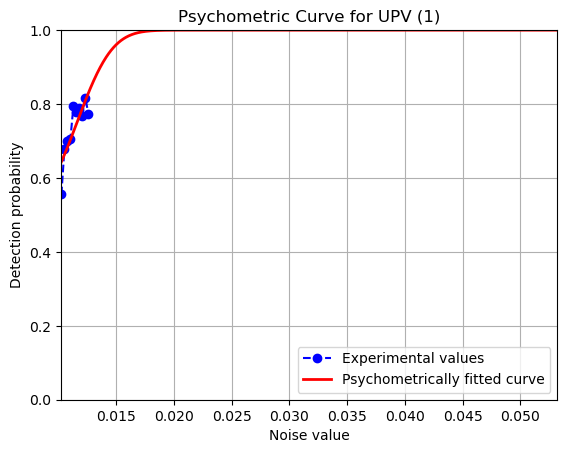

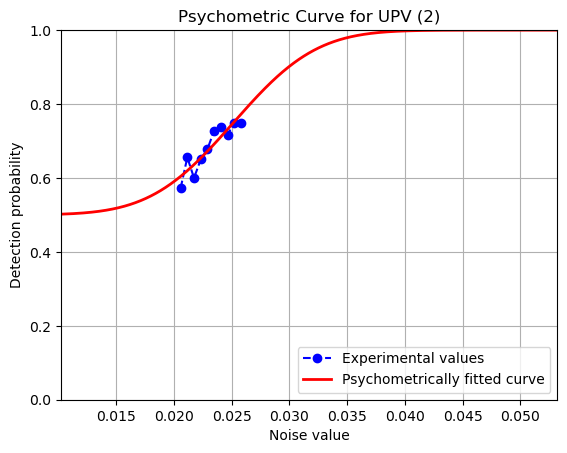

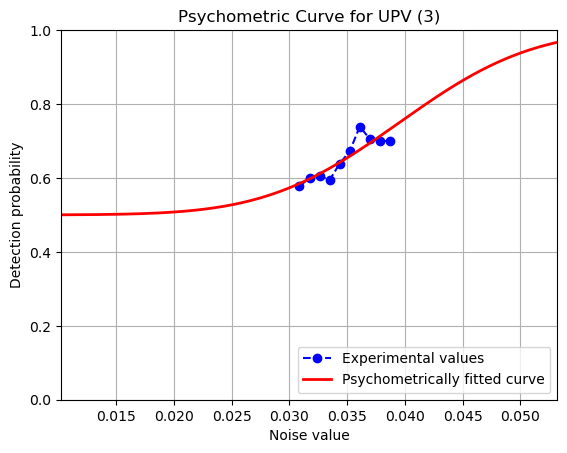

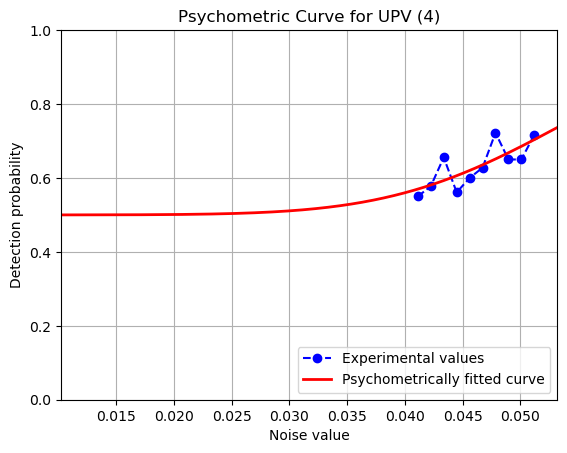

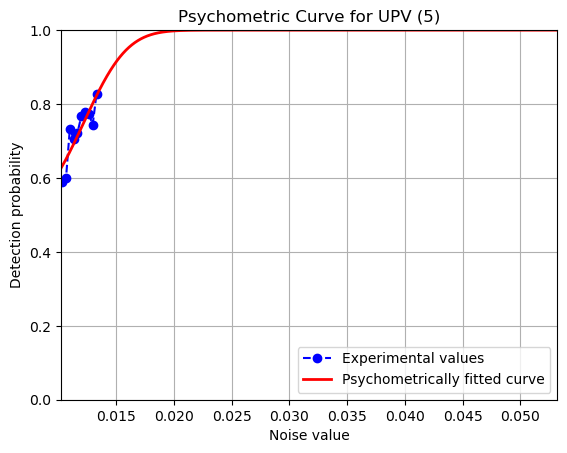

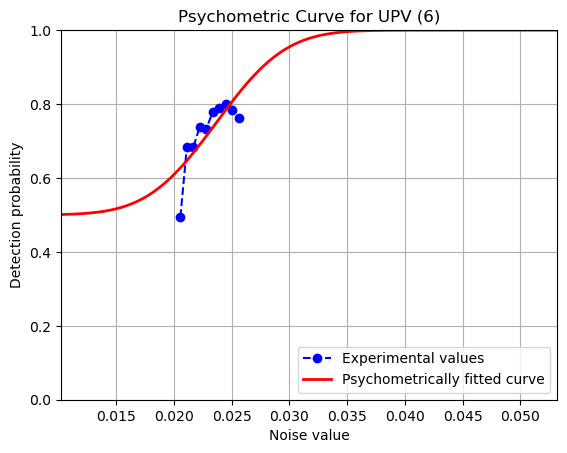

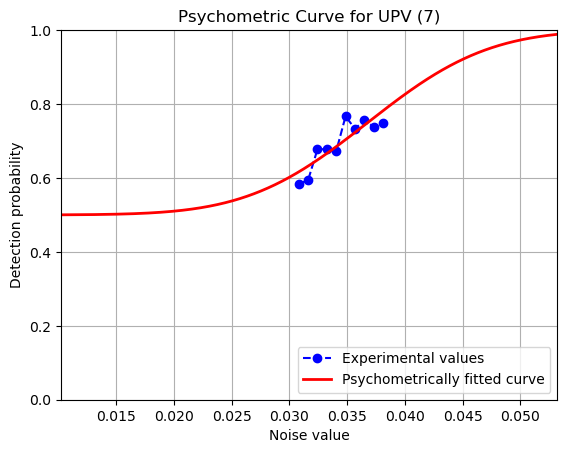

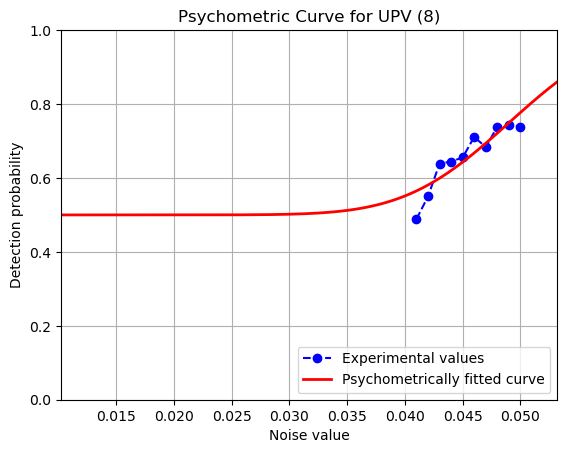

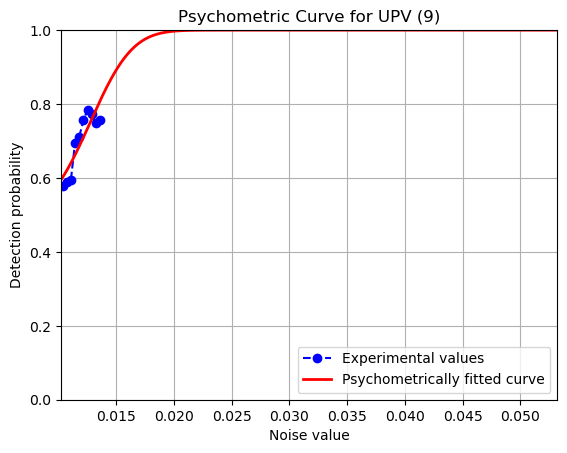

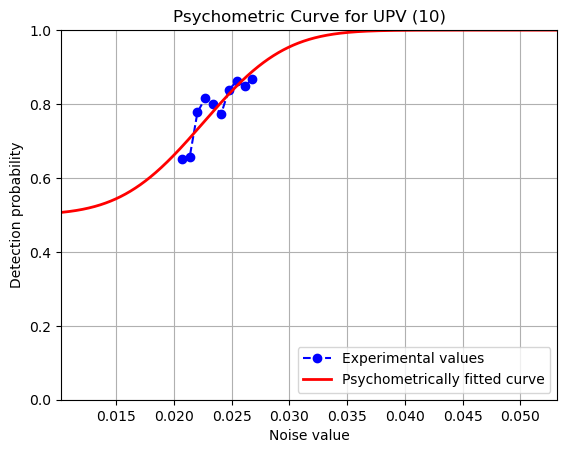

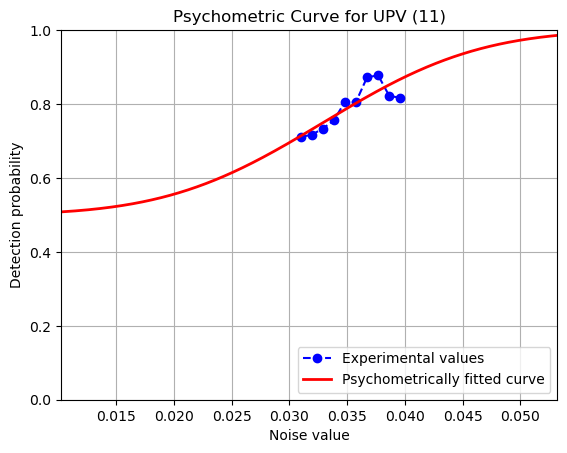

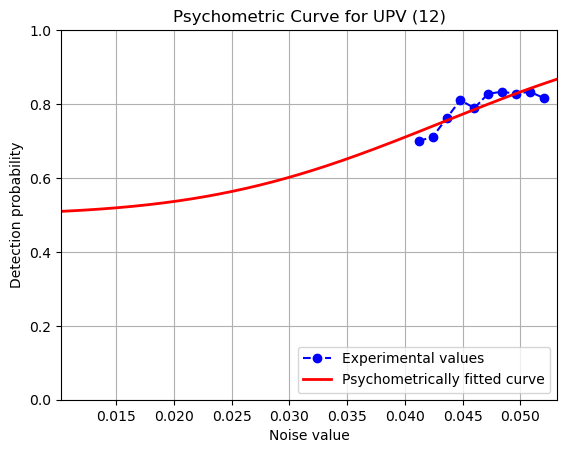

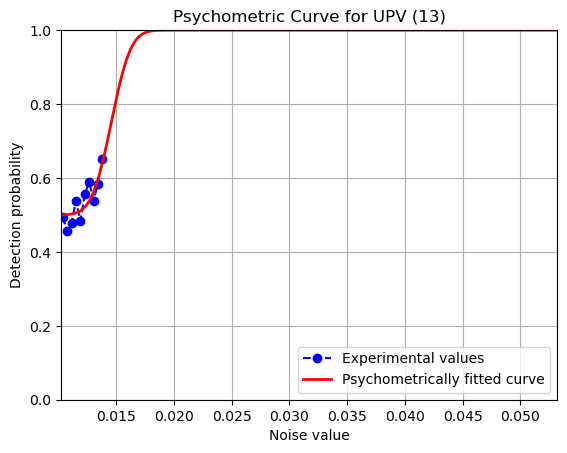

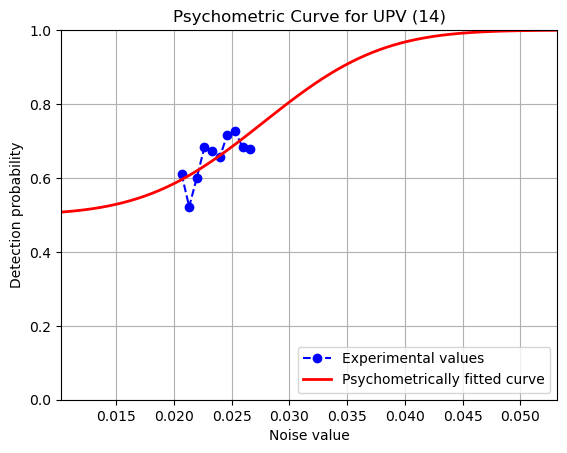

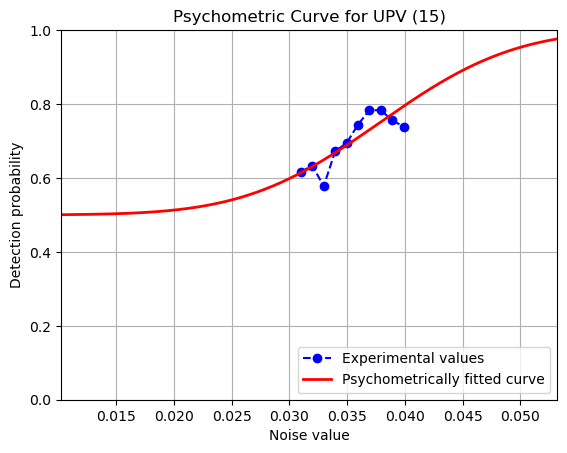

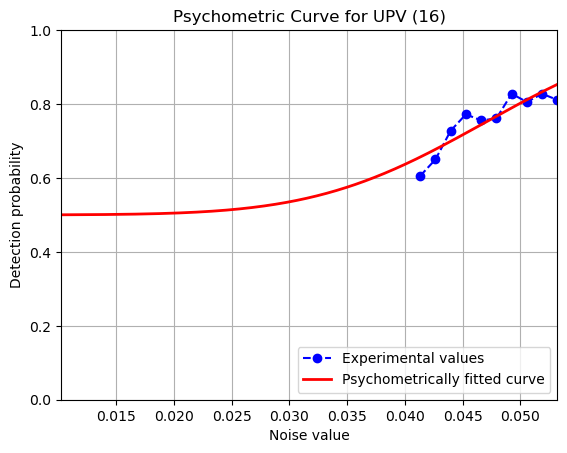

<Figure size 640x480 with 0 Axes>

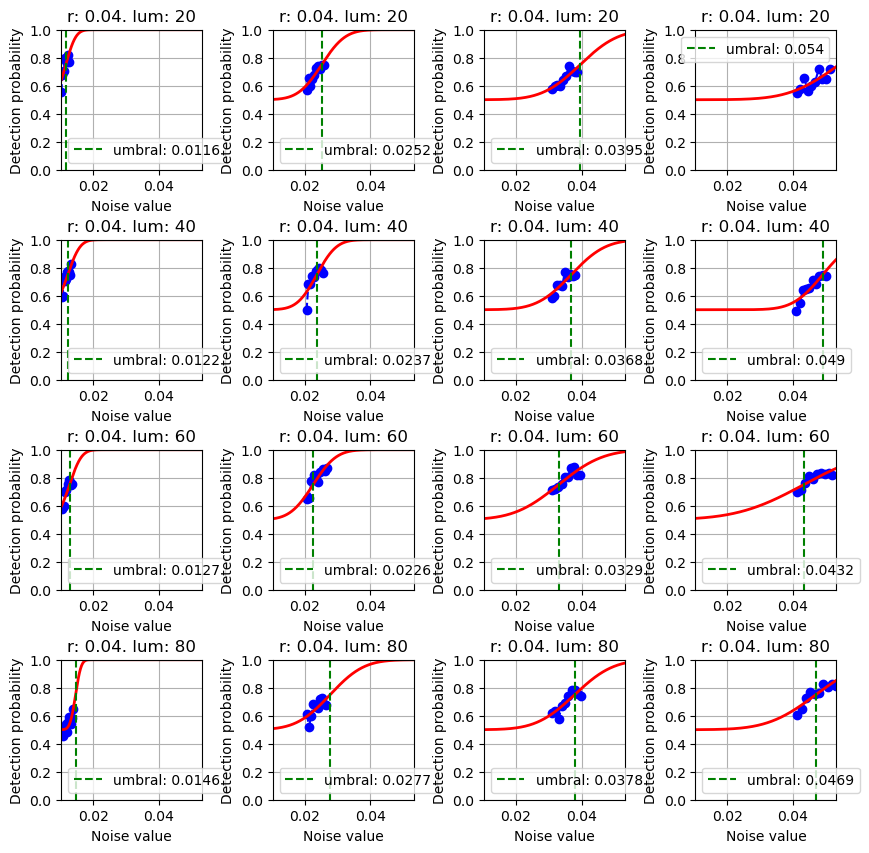

<Figure size 640x480 with 0 Axes>

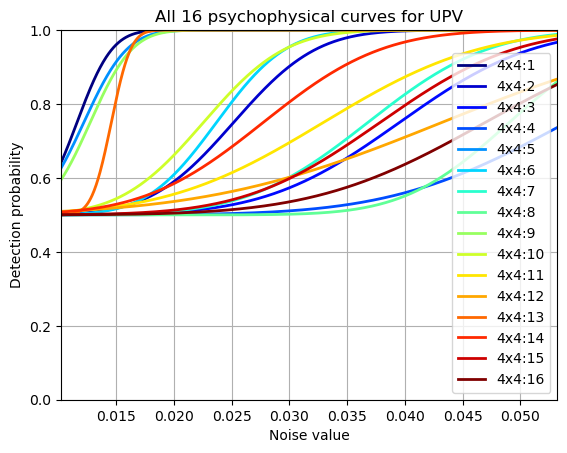

In [16]:
# UPV
mean_result_upv = None
mean_std_upv = []
count = 0
for fichero in ficheros_upv:
    count = count+1
    data_file = PATH_UPV+'/'+fichero
    result = scipy.io.loadmat(data_file)
    result = np.array(result['Results'])
    if mean_result_upv is None:
        mean_result_upv = result
    else:
        mean_result_upv = mean_result_upv + result 
        # Suma de los resultados
        # Promediar la probabilidad y Promediar el tiempo
print(count)
mean_result_upv = mean_result_upv/len(ficheros_upv) # Media de los resultados para todos los ficheros de la UPV
    
# Individual plot
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    y = mean_result_upv[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # parámetros para el ajuste
    params = {'x': x, 'y': y}

    # minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # media y la desviación estándar de la distribución ajustada
    # Se corresponde al umbral, ruido correspondiente a una prob de detección de 0.75
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    # resultados en gráficos independientes
    plt.figure(i)
    plt.plot(x, y, 'o--b')
    plt.axis([min(x), max(x), 0, 1])
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    plt.plot(x_curve, y_curve, '-r', linewidth=2)
    plt.title('Psychometric Curve for UPV ('+ str(i+1)+")")
    plt.xlabel('Noise value')
    plt.ylabel('Detection probability')
    plt.legend(['Experimental values', 'Psychometrically fitted curve'], loc='lower right')
    plt.grid(True)
    plt.xlim([minX, maxX])
    plt.ylim([0, 1])

    # Guardar el gráfico y los datos en .npy
    plt.savefig(RESULTS_PATH_UPV+'/UPV-plot-' + str(i+1) + '.png')
    np.save(RESULTS_PATH_UPV+'/UPV-MeanStdDistribution-' + str(i+1) + '.npy', meanAndStdDistrib)
    
    plt.show()
    mean_std_upv.append((ruido_base, round(ParamsOpt[0], 6), round(ParamsOpt[1], 6)))


# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_upv[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x, y, 'o--b')
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.axvline(x=ParamsOpt[0], color='g', linestyle='--', label="umbral: {}".format(round(ParamsOpt[0],4)))
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_title("r: {}. lum: {}".format(ruido_base, luminancias[i]))
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')
    ax.legend()

plt.savefig(RESULTS_PATH_UPV+'/UPV-MosaicWithEqualXAxes-' + str(i+1) + '.png')


# All 16 psychophysical curves

plt.figure() 
cc = plt.get_cmap('jet')(np.linspace(0, 1, 16))

fig, ax = plt.subplots()
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_upv[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, linewidth=2, color=cc[i])
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

ax.set_title('All 16 psychophysical curves for UPV')

Legend = []
for i in range(16):
    Legend.append('4x4:{}'.format(i+1))

ax.legend(Legend)

plt.savefig(RESULTS_PATH_UPV+'/UPV-AllPsychomPlots-' + str(i+1) + '.png')

<Figure size 640x480 with 0 Axes>

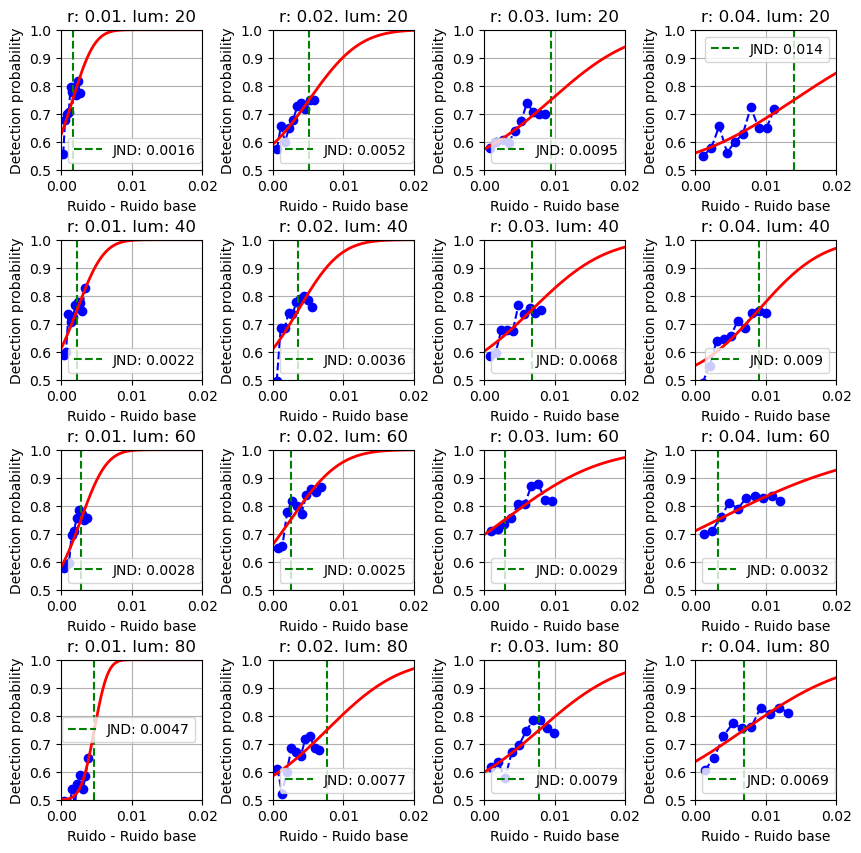

In [17]:
# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    x_less_r = x-ruido_base
    y = mean_result_upv[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x_less_r), 0.1*np.mean(x_less_r)]

    # Definir los parámetros para el ajuste
    params = {'x': x_less_r, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x_less_r, y, 'o--b')
    ax.axvline(x=ParamsOpt[0], color='g', linestyle='--', label="JND: {}".format(round(ParamsOpt[0],4)))
    x_curve = np.linspace(0, 0.02, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.grid(True)
    ax.set_xlim([0, 0.02])
    ax.set_ylim([0.5, 1])
    ax.set_title("r: {}. lum: {}".format(ruido_base, luminancias[i]))
    ax.set_xlabel('Ruido - Ruido base')
    ax.set_ylabel('Detection probability')
    ax.legend()

In [18]:
data_upv = [row for row in [mean_std_upv[i:i+4] for i in range(0, 16, 4)]]
for row in data_upv:
    print(row)
mean_std_upv

[(0.01, 0.011607, 0.002403), (0.02, 0.025164, 0.005649), (0.03, 0.039522, 0.009064), (0.04, 0.053994, 0.011909)]
[(0.01, 0.012196, 0.00296), (0.02, 0.02368, 0.004724), (0.03, 0.036786, 0.008197), (0.04, 0.049028, 0.007125)]
[(0.01, 0.012747, 0.002871), (0.02, 0.022552, 0.005572), (0.03, 0.032933, 0.01064), (0.04, 0.043185, 0.015927)]
[(0.01, 0.014579, 0.001328), (0.02, 0.027725, 0.008075), (0.03, 0.037835, 0.009188), (0.04, 0.046935, 0.011525)]


[(0.01, 0.011607, 0.002403),
 (0.02, 0.025164, 0.005649),
 (0.03, 0.039522, 0.009064),
 (0.04, 0.053994, 0.011909),
 (0.01, 0.012196, 0.00296),
 (0.02, 0.02368, 0.004724),
 (0.03, 0.036786, 0.008197),
 (0.04, 0.049028, 0.007125),
 (0.01, 0.012747, 0.002871),
 (0.02, 0.022552, 0.005572),
 (0.03, 0.032933, 0.01064),
 (0.04, 0.043185, 0.015927),
 (0.01, 0.014579, 0.001328),
 (0.02, 0.027725, 0.008075),
 (0.03, 0.037835, 0.009188),
 (0.04, 0.046935, 0.011525)]

73


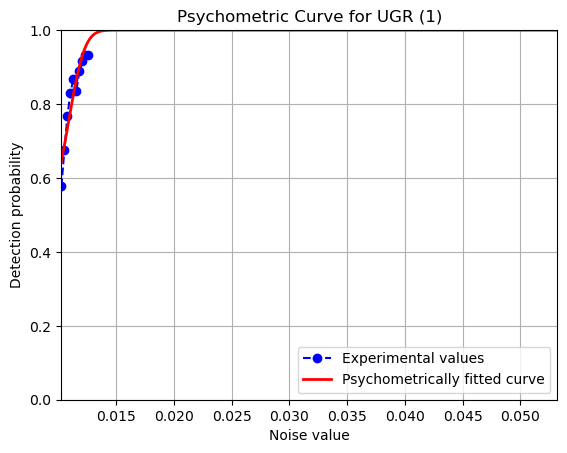

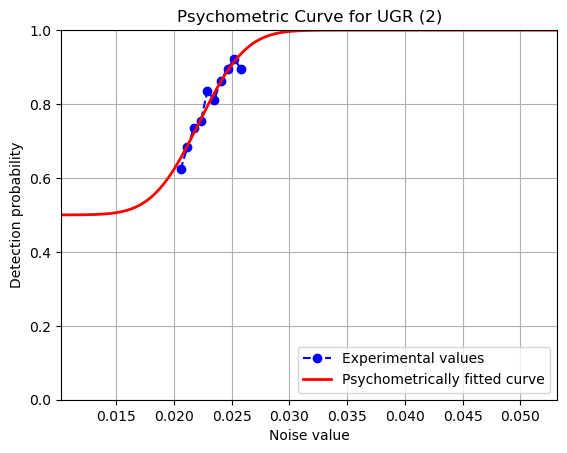

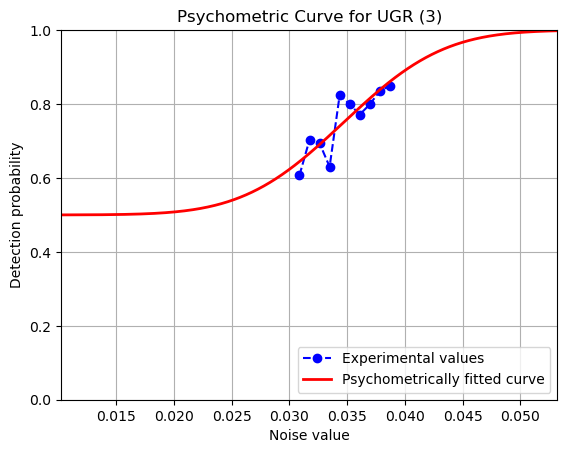

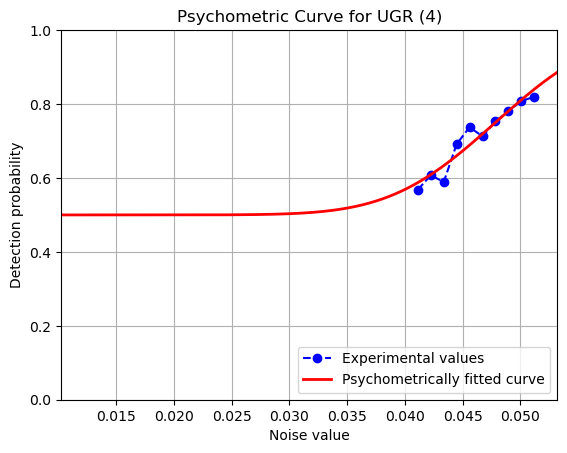

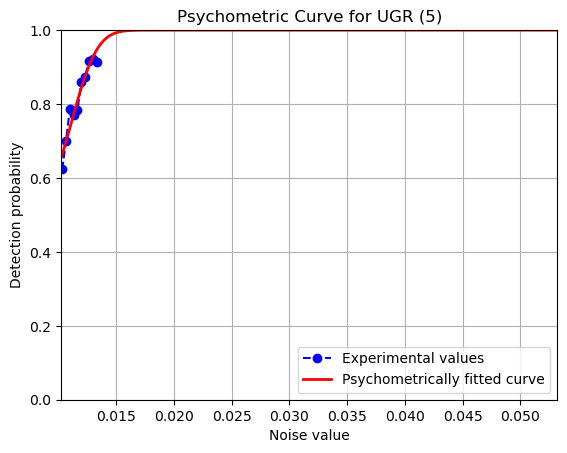

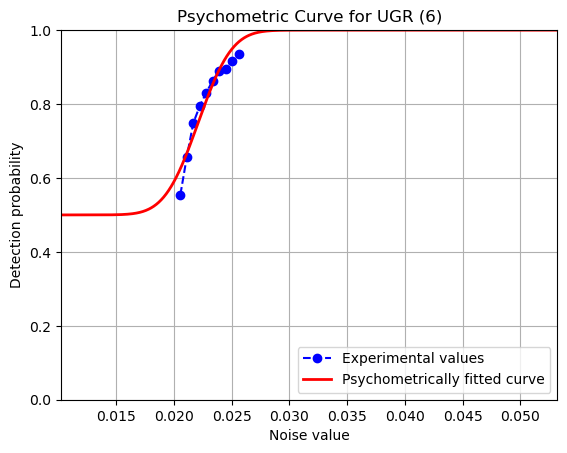

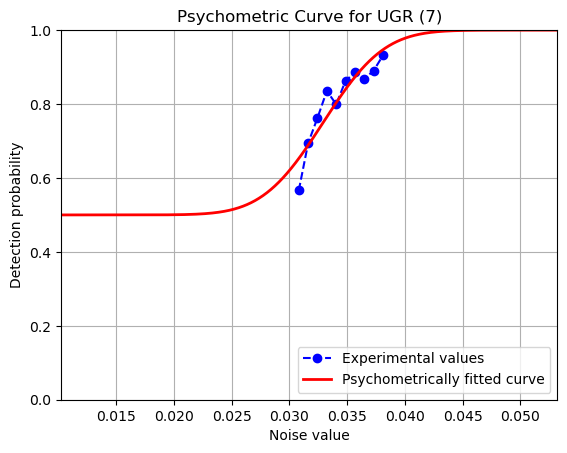

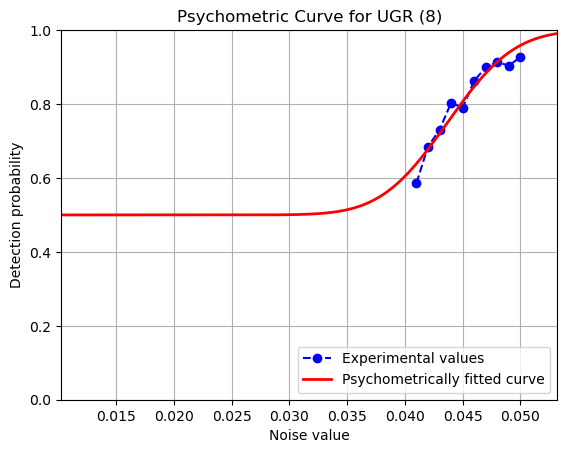

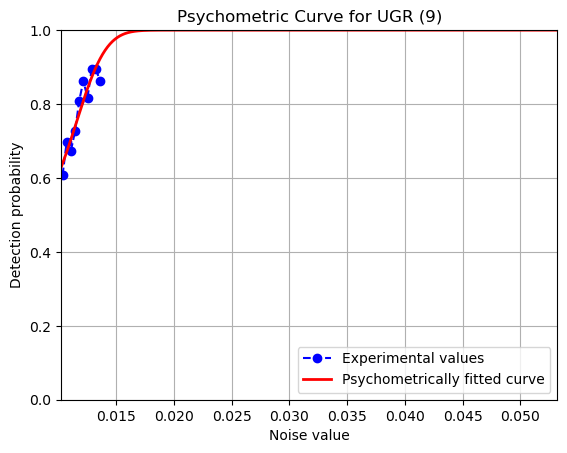

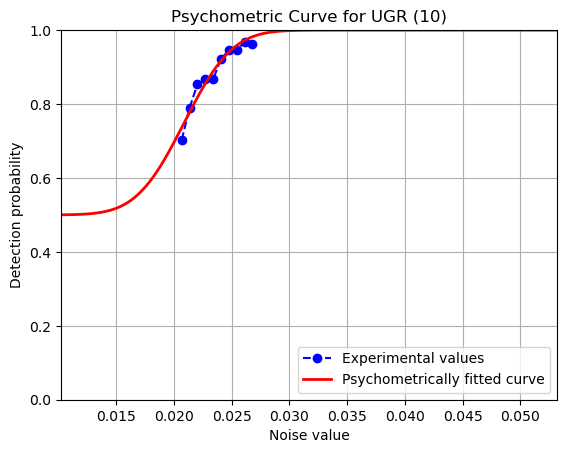

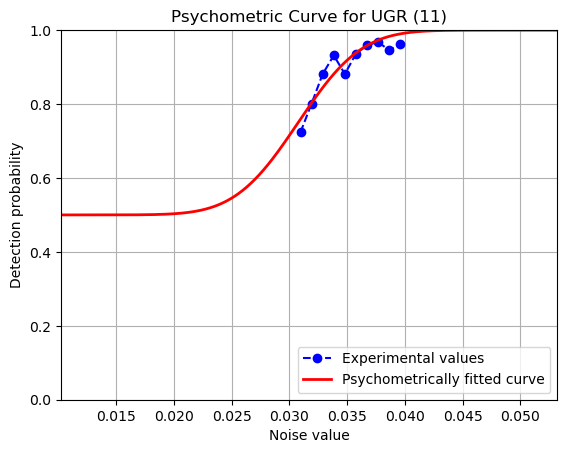

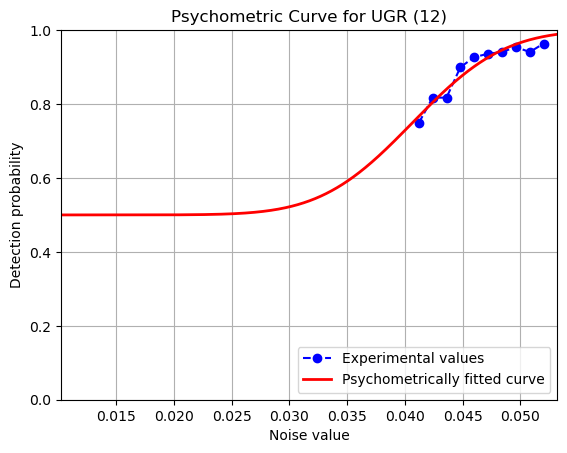

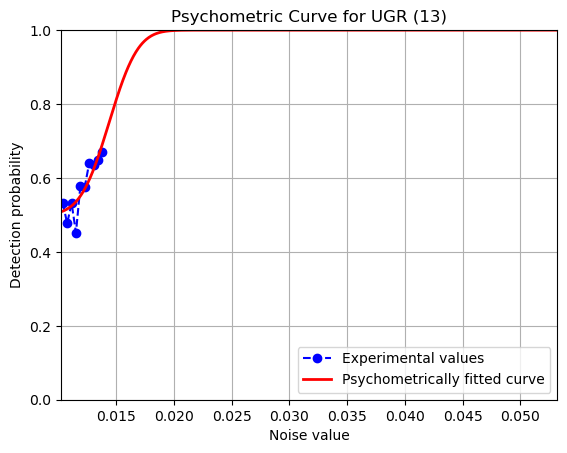

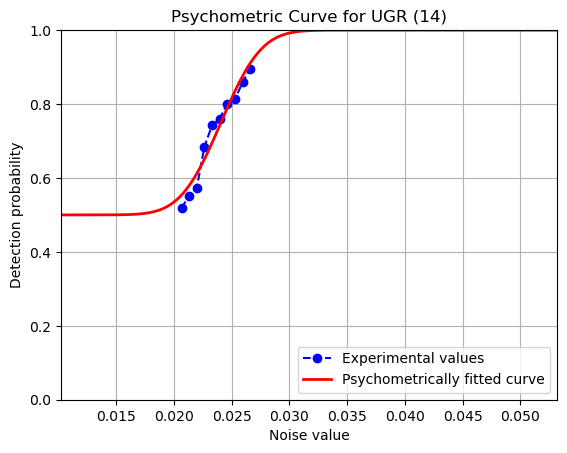

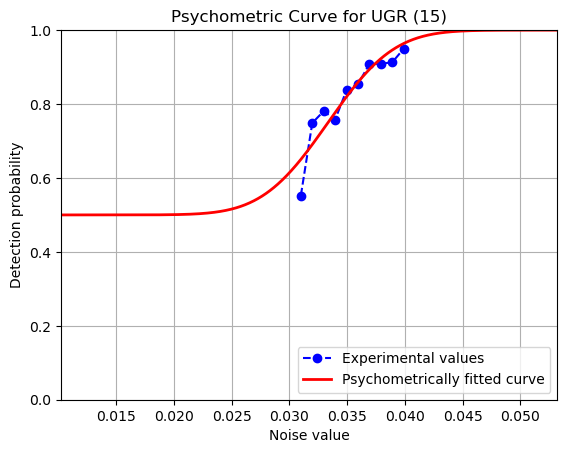

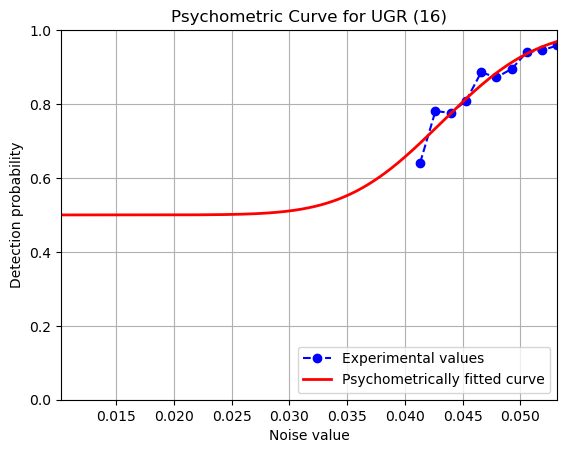

<Figure size 640x480 with 0 Axes>

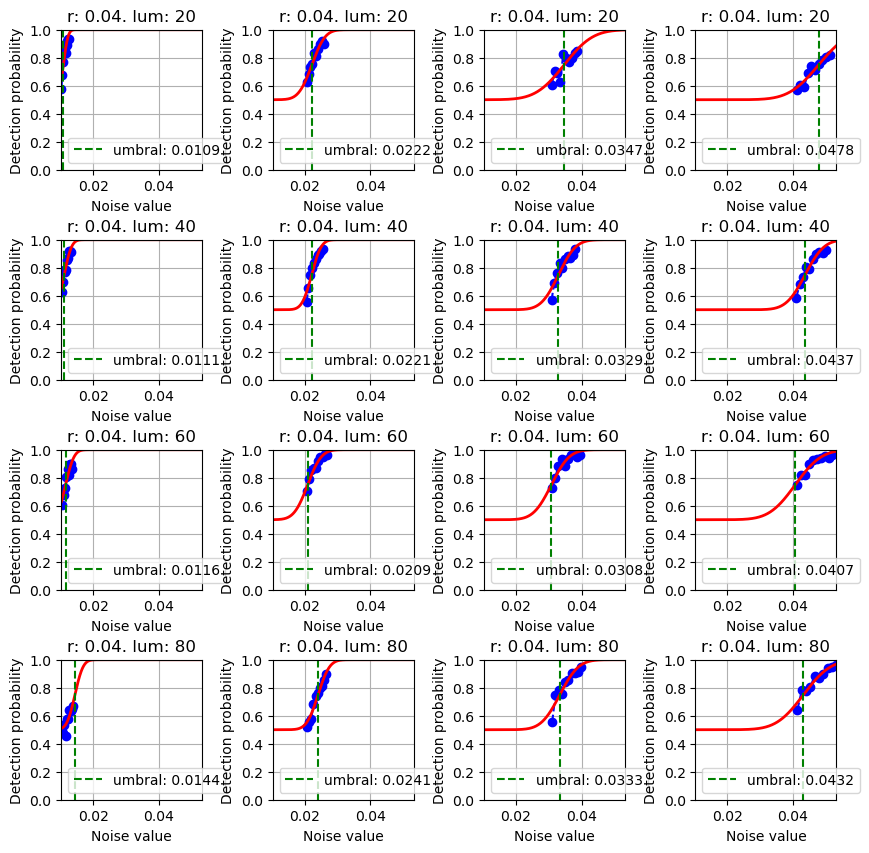

<Figure size 640x480 with 0 Axes>

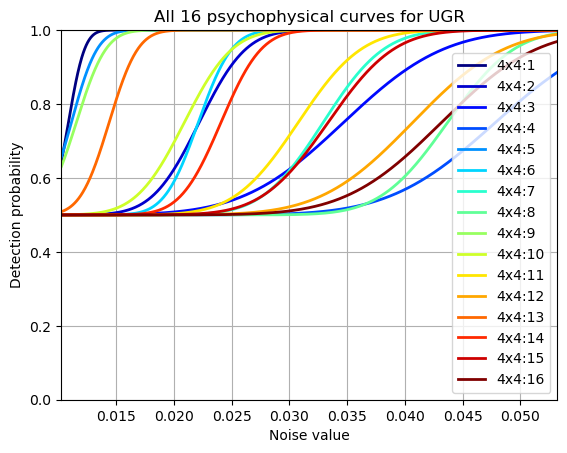

In [19]:
# UGR
mean_result_ugr = None
mean_std_ugr = []
count = 0
for fichero in ficheros_ugr:
    count = count+1
    data_file = PATH_UGR+'/'+fichero
    result = scipy.io.loadmat(data_file)
    result = np.array(result['Results'])
    if mean_result_ugr is None:
        mean_result_ugr = result
    else:
        mean_result_ugr = mean_result_ugr + result 
        # Suma de los resultados
        # Promediar la probabilidad y Promediar el tiempo
print(count)
mean_result_ugr = mean_result_ugr/len(ficheros_ugr) # Media de los resultados para todos los ficheros de la UGR
    
# Individual plot
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    y = mean_result_ugr[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # parámetros para el ajuste
    params = {'x': x, 'y': y}

    # minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    # resultados en gráficos independientes
    plt.figure(i)
    plt.plot(x, y, 'o--b')
    plt.axis([min(x), max(x), 0, 1])
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    plt.plot(x_curve, y_curve, '-r', linewidth=2)
    plt.title('Psychometric Curve for UGR ('+ str(i+1)+")")
    plt.xlabel('Noise value')
    plt.ylabel('Detection probability')
    plt.legend(['Experimental values', 'Psychometrically fitted curve'], loc='lower right')
    plt.grid(True)
    plt.xlim([minX, maxX])
    plt.ylim([0, 1])

    # Guardar el gráfico y los datos en .npy
    plt.savefig(RESULTS_PATH_UGR+'/UGR-plot-' + str(i+1) + '.png')
    np.save(RESULTS_PATH_UGR+'/UGR-MeanStdDistribution-' + str(i+1) + '.npy', meanAndStdDistrib)
    mean_std_ugr.append((ruido_base, round(ParamsOpt[0], 6), round(ParamsOpt[1], 6)))

    plt.show()


# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_ugr[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x, y, 'o--b')
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.axvline(x=ParamsOpt[0], color='g', linestyle='--', label="umbral: {}".format(round(ParamsOpt[0],4)))
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_title("r: {}. lum: {}".format(ruido_base, luminancias[i]))
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')
    ax.legend()
    
plt.savefig(RESULTS_PATH_UGR+'/UGR-MosaicWithEqualXAxes-' + str(i+1) + '.png')

# All 16 psychophysical curves

plt.figure() 
cc = plt.get_cmap('jet')(np.linspace(0, 1, 16))

fig, ax = plt.subplots()
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_ugr[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, linewidth=2, color=cc[i])
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

ax.set_title('All 16 psychophysical curves for UGR')

Legend = []
for i in range(16):
    Legend.append('4x4:{}'.format(i+1))

ax.legend(Legend)

plt.savefig(RESULTS_PATH_UGR+'/UGR-AllPsychomPlots-' + str(i+1) + '.png')
print()

<Figure size 640x480 with 0 Axes>

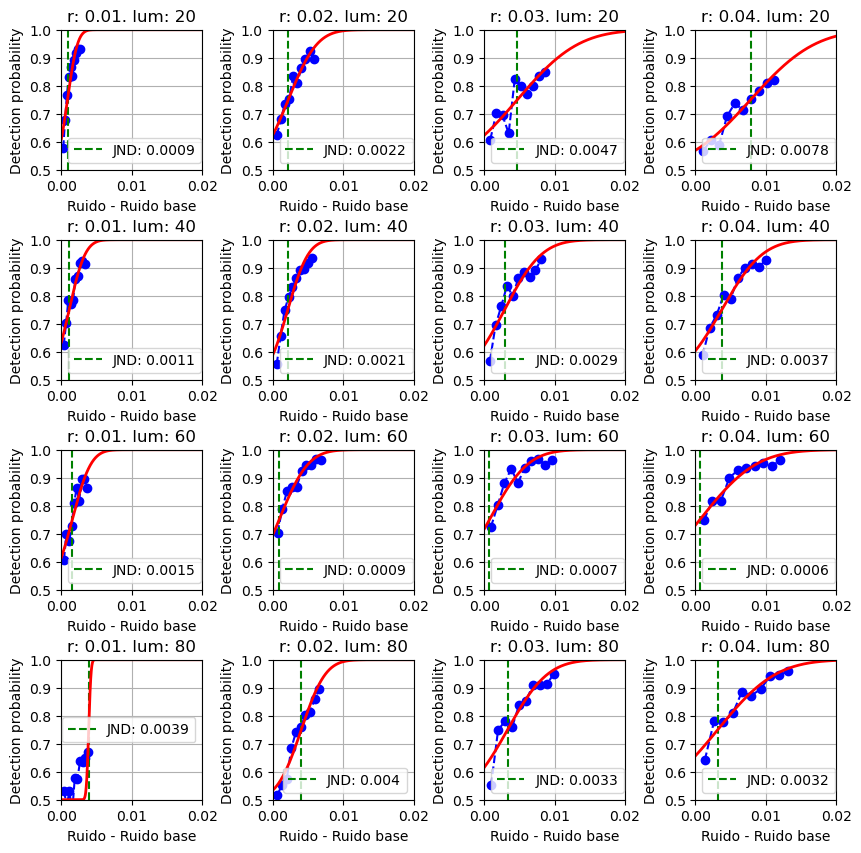

In [20]:
# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    x_less_r = x-ruido_base
    y = mean_result_ugr[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x_less_r), 0.1*np.mean(x_less_r)]

    # Definir los parámetros para el ajuste
    params = {'x': x_less_r, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x_less_r, y, 'o--b')
    ax.axvline(x=ParamsOpt[0], color='g', linestyle='--', label="JND: {}".format(round(ParamsOpt[0],4)))
    x_curve = np.linspace(0, 0.02, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.grid(True)
    ax.set_xlim([0, 0.02])
    ax.set_ylim([0.5, 1])
    ax.set_title("r: {}. lum: {}".format(ruido_base, luminancias[i]))
    ax.set_xlabel('Ruido - Ruido base')
    ax.set_ylabel('Detection probability')
    ax.legend()

In [21]:
data_ugr = [row for row in [mean_std_ugr[i:i+4] for i in range(0, 16, 4)]]
for row in data_ugr:
    print(row)
mean_std_ugr

[(0.01, 0.010867, 0.001107), (0.02, 0.022187, 0.003187), (0.03, 0.034682, 0.006838), (0.04, 0.047834, 0.007186)]
[(0.01, 0.011123, 0.001766), (0.02, 0.022106, 0.002299), (0.03, 0.032921, 0.004147), (0.04, 0.043683, 0.004548)]
[(0.01, 0.011551, 0.002026), (0.02, 0.020899, 0.003275), (0.03, 0.030758, 0.004312), (0.04, 0.040668, 0.006249)]
[(0.01, 0.01439, 0.00196), (0.02, 0.024073, 0.002754), (0.03, 0.03334, 0.004492), (0.04, 0.043154, 0.006503)]


[(0.01, 0.010867, 0.001107),
 (0.02, 0.022187, 0.003187),
 (0.03, 0.034682, 0.006838),
 (0.04, 0.047834, 0.007186),
 (0.01, 0.011123, 0.001766),
 (0.02, 0.022106, 0.002299),
 (0.03, 0.032921, 0.004147),
 (0.04, 0.043683, 0.004548),
 (0.01, 0.011551, 0.002026),
 (0.02, 0.020899, 0.003275),
 (0.03, 0.030758, 0.004312),
 (0.04, 0.040668, 0.006249),
 (0.01, 0.01439, 0.00196),
 (0.02, 0.024073, 0.002754),
 (0.03, 0.03334, 0.004492),
 (0.04, 0.043154, 0.006503)]

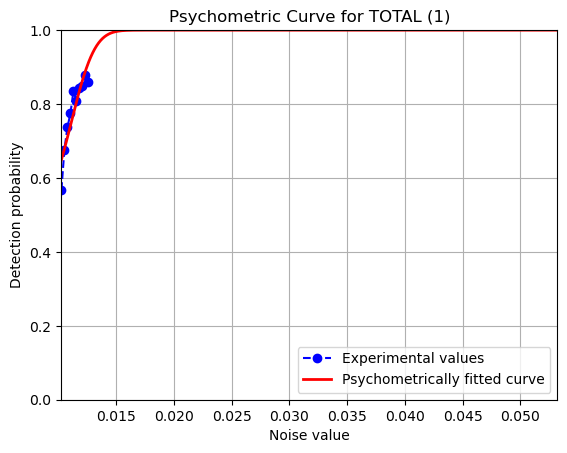

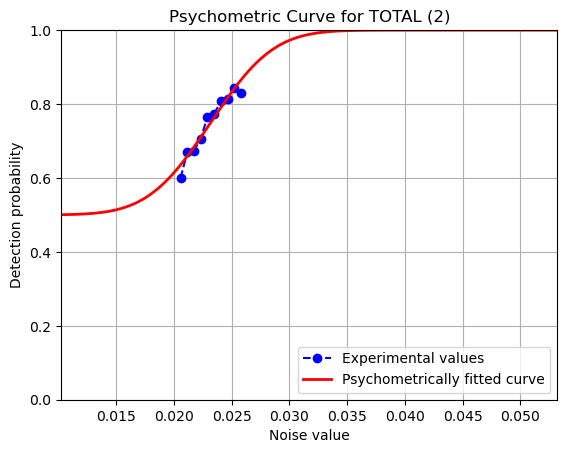

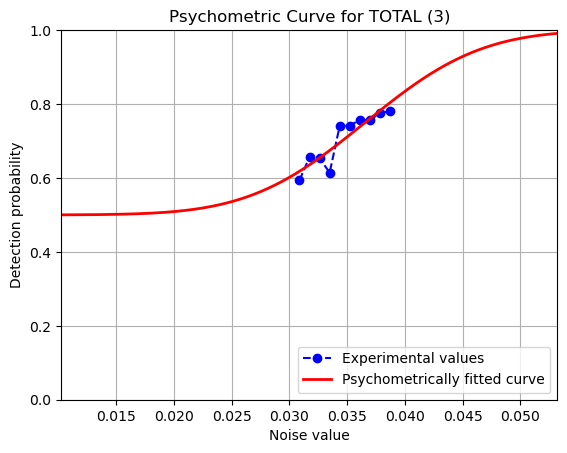

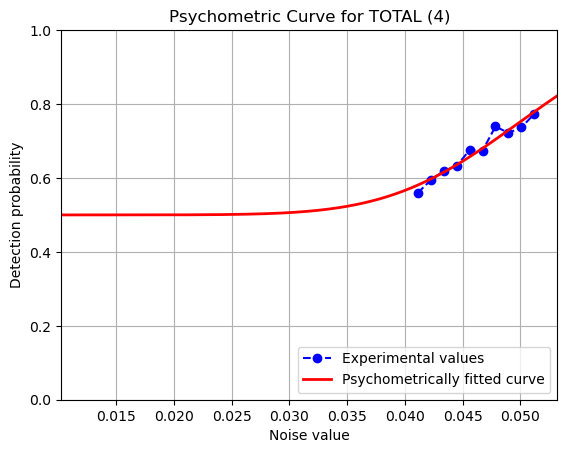

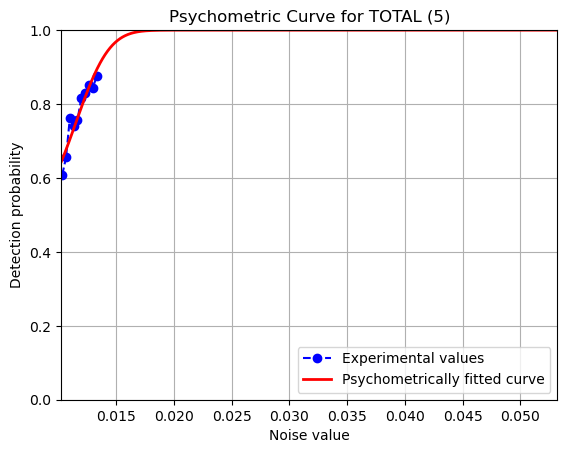

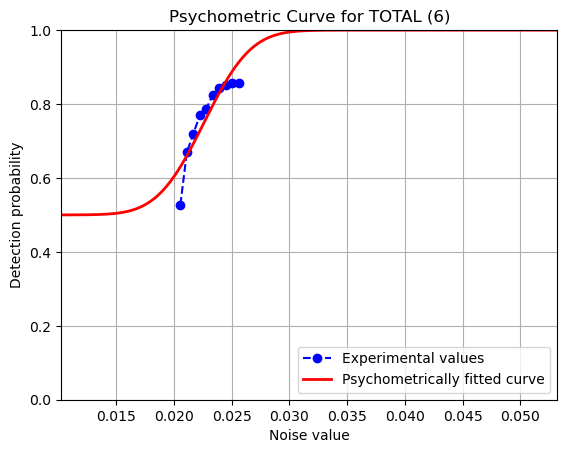

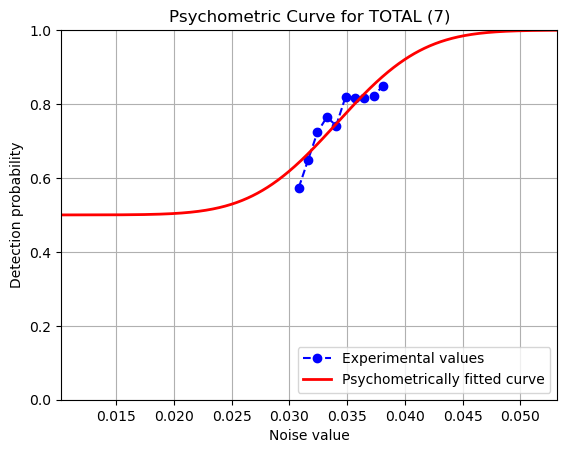

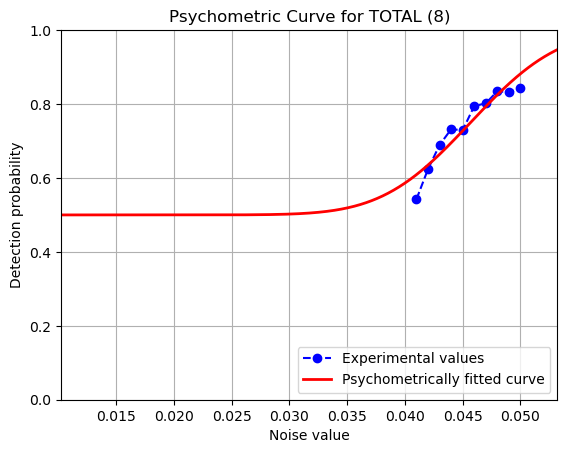

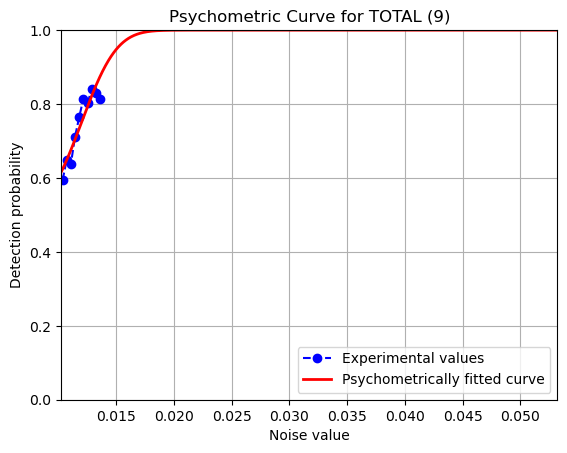

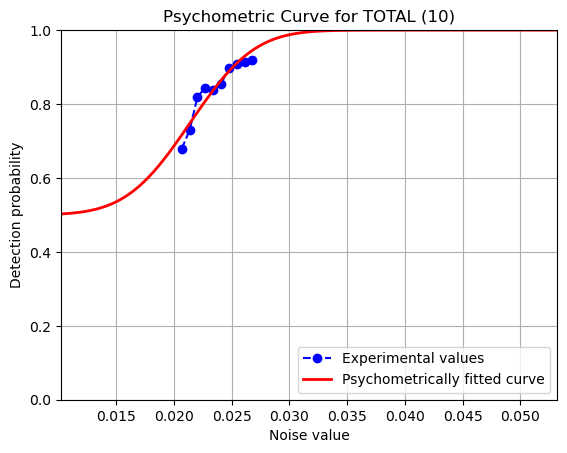

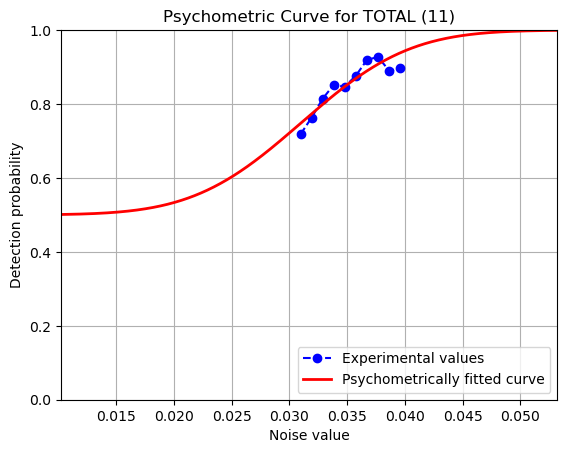

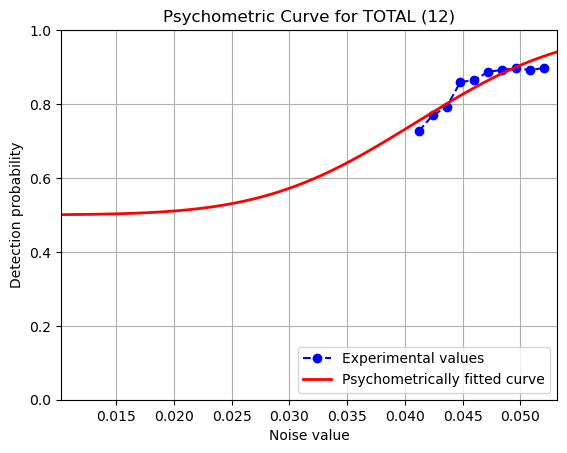

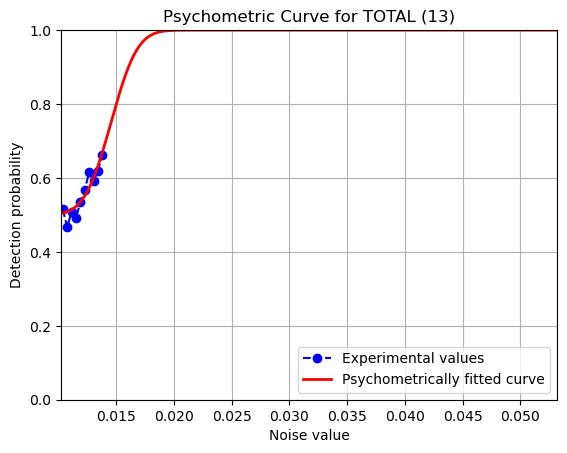

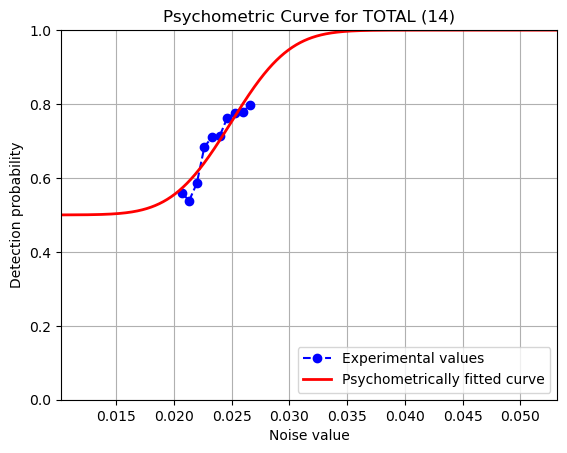

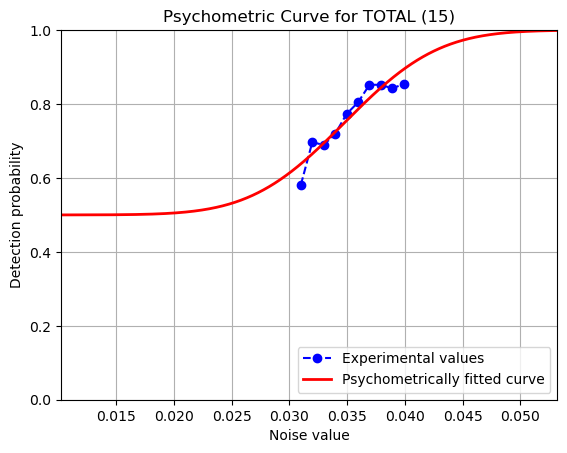

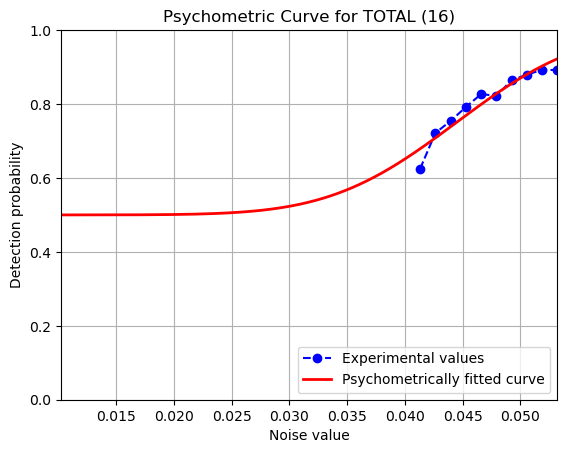

<Figure size 640x480 with 0 Axes>

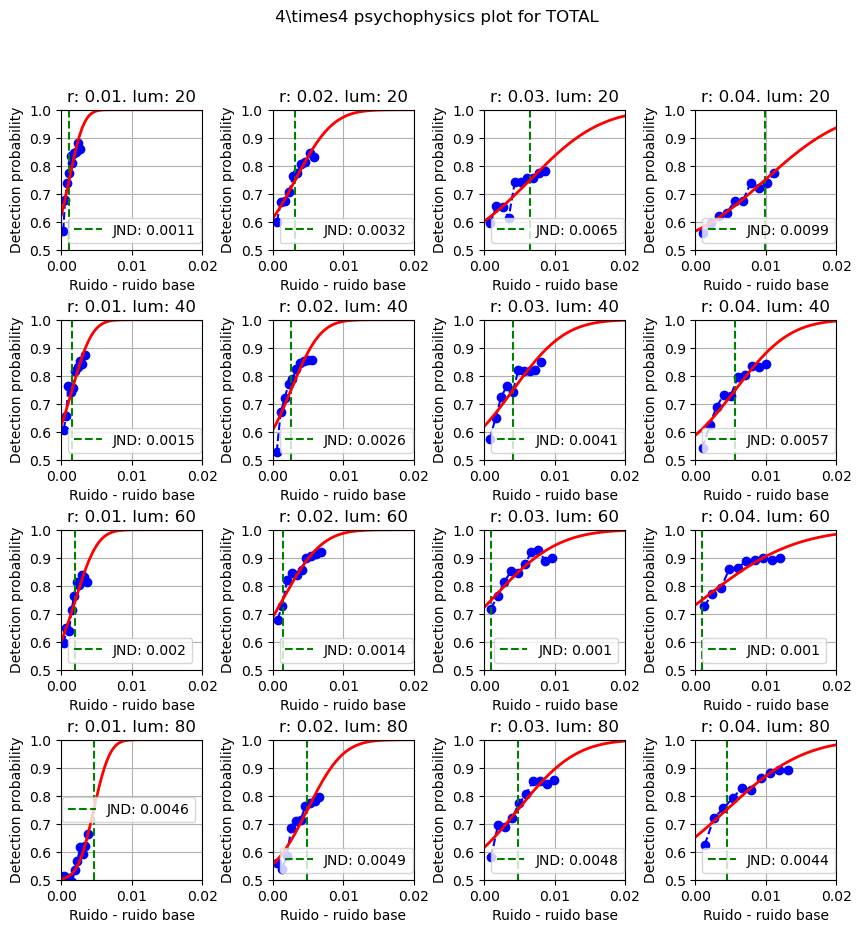

<Figure size 640x480 with 0 Axes>

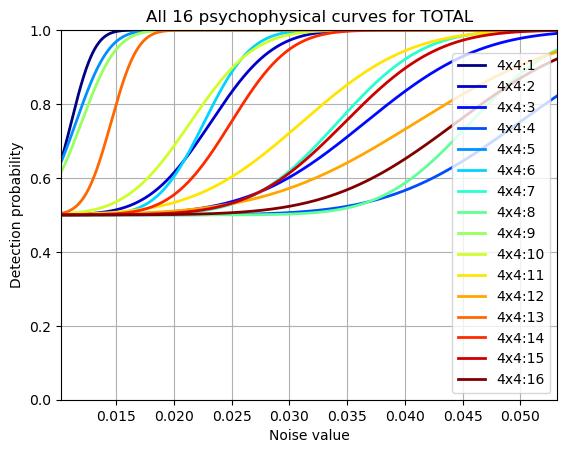

In [22]:
# TOTAL UGR + UPV

mean_result_total = None
mean_std_total = []
for fichero in ficheros_total:
    data_file = fichero
    result = scipy.io.loadmat(data_file)
    result = np.array(result['Results'])
    if mean_result_total is None:
        mean_result_total = result
    else:
        mean_result_total = mean_result_total + result 
        # Suma de los resultados
        # Promediar la probabilidad y Promediar el tiempo
mean_result_total = mean_result_total/len(ficheros_total) # Media de los resultados para todos los ficheros de la TOTAL
    
# Individual plot
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    y = mean_result_total[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # parámetros para el ajuste
    params = {'x': x, 'y': y}

    # minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    # resultados en gráficos independientes
    plt.figure(i)
    plt.plot(x, y, 'o--b')
    plt.axis([min(x), max(x), 0, 1])
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    plt.plot(x_curve, y_curve, '-r', linewidth=2)
    plt.title('Psychometric Curve for TOTAL ('+ str(i+1)+")")
    plt.xlabel('Noise value')
    plt.ylabel('Detection probability')
    plt.legend(['Experimental values', 'Psychometrically fitted curve'], loc='lower right')
    plt.grid(True)
    plt.xlim([minX, maxX])
    plt.ylim([0, 1])

    # Guardar el gráfico y los datos en .npy
    plt.savefig(RESULTS_PATH_TOTAL+'/TOTAL-plot-' + str(i+1) + '.png')
    np.save(RESULTS_PATH_TOTAL+'/TOTAL-MeanStdDistribution-' + str(i+1) + '.npy', meanAndStdDistrib)
    mean_std_total.append((ruido_base, round(ParamsOpt[0], 6), round(ParamsOpt[1], 6)))

    plt.show()


# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    x_less_r = x-ruido_base
    y = mean_result_total[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x_less_r), 0.1*np.mean(x_less_r)]

    # Definir los parámetros para el ajuste
    params = {'x': x_less_r, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x_less_r, y, 'o--b')
    ax.axvline(x=ParamsOpt[0], color='g', linestyle='--', label="JND: {}".format(round(ParamsOpt[0],4)))
    x_curve = np.linspace(0, 0.02, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.grid(True)
    ax.set_xlim([0, 0.02])
    ax.set_ylim([0.5, 1])
    ax.set_title("r: {}. lum: {}".format(ruido_base, luminancias[i]))
    ax.set_xlabel('Ruido - ruido base')
    ax.set_ylabel('Detection probability')
    ax.legend()

figure.suptitle('4\\times4 psychophysics plot for TOTAL')
plt.savefig(RESULTS_PATH_TOTAL+'/TOTAL-MosaicWithEqualXAxes-' + str(i+1) + '.png')


# All 16 psychophysical curves

plt.figure() 
cc = plt.get_cmap('jet')(np.linspace(0, 1, 16))

fig, ax = plt.subplots()
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_total[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, linewidth=2, color=cc[i])
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

ax.set_title('All 16 psychophysical curves for TOTAL')

Legend = []
for i in range(16):
    Legend.append('4x4:{}'.format(i+1))

ax.legend(Legend)

plt.savefig(RESULTS_PATH_TOTAL+'/TOTAL-AllPsychomPlots-' + str(i+1) + '.png')

<Figure size 640x480 with 0 Axes>

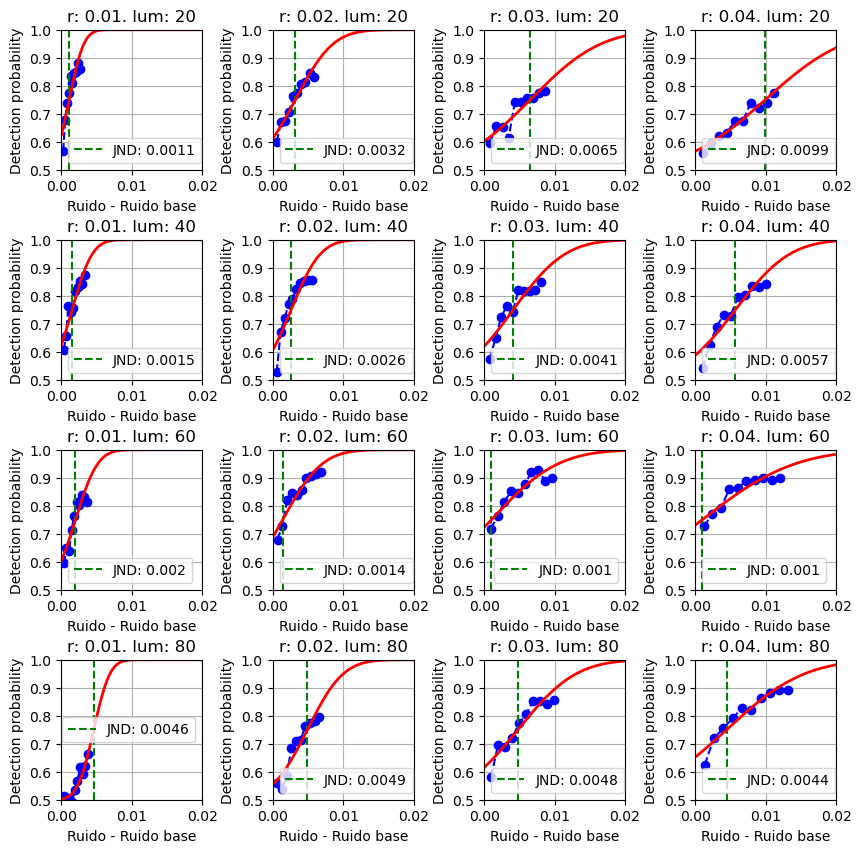

In [30]:
# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    x_less_r = x-ruido_base
    y = mean_result_total[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x_less_r), 0.1*np.mean(x_less_r)]

    # Definir los parámetros para el ajuste
    params = {'x': x_less_r, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x_less_r, y, 'o--b')
    ax.axvline(x=ParamsOpt[0], color='g', linestyle='--', label="JND: {}".format(round(ParamsOpt[0],4)))
    x_curve = np.linspace(0, 0.02, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.grid(True)
    ax.set_xlim([0, 0.02])
    ax.set_ylim([0.5, 1])
    ax.set_title("r: {}. lum: {}".format(ruido_base, luminancias[i]))
    ax.set_xlabel('Ruido - Ruido base')
    ax.set_ylabel('Detection probability')
    ax.legend()

In [23]:
data_total = [row for row in [mean_std_total[i:i+4] for i in range(0, 16, 4)]]
for row in data_total:
    print(row)
data_total

[(0.01, 0.011109, 0.001602), (0.02, 0.023179, 0.004269), (0.03, 0.036551, 0.0079), (0.04, 0.049895, 0.008882)]
[(0.01, 0.011517, 0.002267), (0.02, 0.022611, 0.003197), (0.03, 0.034158, 0.00583), (0.04, 0.045681, 0.006012)]
[(0.01, 0.011995, 0.002395), (0.02, 0.021421, 0.004373), (0.03, 0.031045, 0.007363), (0.04, 0.040944, 0.010311)]
[(0.01, 0.014554, 0.001798), (0.02, 0.024944, 0.00401), (0.03, 0.034783, 0.006386), (0.04, 0.044452, 0.008614)]


[[(0.01, 0.011109, 0.001602),
  (0.02, 0.023179, 0.004269),
  (0.03, 0.036551, 0.0079),
  (0.04, 0.049895, 0.008882)],
 [(0.01, 0.011517, 0.002267),
  (0.02, 0.022611, 0.003197),
  (0.03, 0.034158, 0.00583),
  (0.04, 0.045681, 0.006012)],
 [(0.01, 0.011995, 0.002395),
  (0.02, 0.021421, 0.004373),
  (0.03, 0.031045, 0.007363),
  (0.04, 0.040944, 0.010311)],
 [(0.01, 0.014554, 0.001798),
  (0.02, 0.024944, 0.00401),
  (0.03, 0.034783, 0.006386),
  (0.04, 0.044452, 0.008614)]]

In [26]:
import pickle

# Importar el diccionario
with open("./variables/voluntarios.pkl", 'rb') as archivo:
    general_stats_dict = pickle.load(archivo)

In [27]:
general_stats_dict

{'khleef-almutairi': {'nombre': 'Khleef',
  'apellidos': 'Almutairi',
  'edad': 31,
  'genero': 'H',
  'experto': True,
  'data_files': ['ResultsJNDsNoiseFlatBG20211129T112353.mat',
   'ResultsJNDsNoiseFlatBG20211129T120005.mat'],
  'universidad': 'UPV'},
 'juan-giner': {'nombre': 'Juan',
  'apellidos': 'Giner',
  'edad': 60,
  'genero': 'H',
  'experto': False,
  'data_files': ['ResultsJNDsNoiseFlatBG20211129T133717.mat',
   'ResultsJNDsNoiseFlatBG20211129T140322.mat'],
  'universidad': 'UPV'},
 'sergio-camp': {'nombre': 'Sergio',
  'apellidos': 'Camp',
  'edad': 49,
  'genero': 'H',
  'experto': False,
  'data_files': ['ResultsJNDsNoiseFlatBG20211129T163621.mat',
   'ResultsJNDsNoiseFlatBG20211129T171934.mat'],
  'universidad': 'UPV'},
 'antonio-hervas': {'nombre': 'Antonio',
  'apellidos': 'Hervas',
  'edad': 63,
  'genero': 'H',
  'experto': False,
  'data_files': ['ResultsJNDsNoiseFlatBG20211130T105700.mat',
   'ResultsJNDsNoiseFlatBG20220111T121738.mat'],
  'universidad': 'UPV'},

In [28]:
# TOTAL UGR + UPV agrupado por edad, genero y sexo
mean_result_agrupado = {"genero":{"H": None, "M": None}, "experiencia":{"Si": None, "No": None}, "edad": {"<= 23.0": None, "(23.0, 40.22]":None, "> 40.22":None}}
mean_std_total = []
contadores = {"genero":{"H": 0, "M": 0}, "experiencia":{"Si": 0, "No": 0}, "edad": {"<= 23.0": 0, "(23.0, 40.22]":0, "> 40.22":0}}
for fichero in ficheros_total:
    data_file = fichero
    data = scipy.io.loadmat(data_file)
    result = np.array(data['Results'])
    datos = np.array(data['datos'])[0]
    nombre = datos[0][0][0]
    apellidos = datos[0][1][0]
    nombre = unidecode(nombre.lower())
    apellidos = unidecode(apellidos.split(" ")[0].lower())
    clave = f"{nombre}-{apellidos}".replace(" ", "")
    edad = general_stats_dict[clave]["edad"]
    sexo = general_stats_dict[clave]["genero"]
    experiencia = general_stats_dict[clave]["experto"]
    if edad <= 23:
        contadores["edad"]["<= 23.0"] = contadores["edad"]["<= 23.0"] + 1
        if mean_result_agrupado["edad"]["<= 23.0"] is None:
            mean_result_agrupado["edad"]["<= 23.0"] = result
        else:
            mean_result_agrupado["edad"]["<= 23.0"] = mean_result_agrupado["edad"]["<= 23.0"]+result
    elif edad > 40.22:
        contadores["edad"]["> 40.22"] = contadores["edad"]["> 40.22"]+1
        if mean_result_agrupado["edad"]["> 40.22"] is None:
            mean_result_agrupado["edad"]["> 40.22"] = result
        else:
            mean_result_agrupado["edad"]["> 40.22"] = mean_result_agrupado["edad"]["> 40.22"]+result
    else:
        contadores["edad"]["(23.0, 40.22]"] = contadores["edad"]["(23.0, 40.22]"]+1
        if mean_result_agrupado["edad"]["(23.0, 40.22]"] is None:
            mean_result_agrupado["edad"]["(23.0, 40.22]"] = result
        else:
            mean_result_agrupado["edad"]["(23.0, 40.22]"] = mean_result_agrupado["edad"]["(23.0, 40.22]"]+result
            
    if sexo == "H":
        contadores["genero"]["H"] = contadores["genero"]["H"]+1
        if mean_result_agrupado["genero"]["H"] is None:
            mean_result_agrupado["genero"]["H"] = result
        else:
            mean_result_agrupado["genero"]["H"] = mean_result_agrupado["genero"]["H"]+result
    else:
        contadores["genero"]["M"] = contadores["genero"]["M"]+1
        if mean_result_agrupado["genero"]["M"] is None:
            mean_result_agrupado["genero"]["M"] = result
        else:
            mean_result_agrupado["genero"]["M"] = mean_result_agrupado["genero"]["M"]+result
            
    if experiencia:
        contadores["experiencia"]["Si"] = contadores["experiencia"]["Si"]+1
        if mean_result_agrupado["experiencia"]["Si"] is None:
            mean_result_agrupado["experiencia"]["Si"] = result
        else:
            mean_result_agrupado["experiencia"]["Si"] = mean_result_agrupado["experiencia"]["Si"]+result
    else:
        contadores["experiencia"]["No"] = contadores["experiencia"]["No"]+1
        if mean_result_agrupado["experiencia"]["No"] is None:
            mean_result_agrupado["experiencia"]["No"] = result
        else:
            mean_result_agrupado["experiencia"]["No"] = mean_result_agrupado["experiencia"]["No"]+result

mean_result_agrupado["edad"]["<= 23.0"] = mean_result_agrupado["edad"]["<= 23.0"]/contadores["edad"]["<= 23.0"]            
mean_result_agrupado["edad"]["> 40.22"] = mean_result_agrupado["edad"]["> 40.22"]/contadores["edad"]["> 40.22"]         
mean_result_agrupado["edad"]["(23.0, 40.22]"] = mean_result_agrupado["edad"]["(23.0, 40.22]"]/contadores["edad"]["(23.0, 40.22]"]          
mean_result_agrupado["genero"]["H"] = mean_result_agrupado["genero"]["H"]/contadores["genero"]["H"]         
mean_result_agrupado["genero"]["M"] = mean_result_agrupado["genero"]["M"]/contadores["genero"]["M"]         
mean_result_agrupado["experiencia"]["Si"] = mean_result_agrupado["experiencia"]["Si"]/contadores["experiencia"]["Si"]           
mean_result_agrupado["experiencia"]["No"] = mean_result_agrupado["experiencia"]["No"]/contadores["experiencia"]["No"] 

print(contadores)
mean_result_agrupado

{'genero': {'H': 69, 'M': 64}, 'experiencia': {'Si': 29, 'No': 104}, 'edad': {'<= 23.0': 44, '(23.0, 40.22]': 40, '> 40.22': 49}}


{'genero': {'H': array([[0.61594203, 1.96778695],
         [0.66425121, 2.01573132],
         [0.74879227, 2.00026626],
         [0.7826087 , 1.9907973 ],
         [0.85024155, 1.69321373],
         [0.82125604, 1.63113533],
         [0.85990338, 1.45988093],
         [0.88405797, 1.57779216],
         [0.89371981, 1.38147493],
         [0.87439614, 1.33232594],
         [0.59661836, 2.00439152],
         [0.69323671, 1.87877772],
         [0.7294686 , 1.76923521],
         [0.75362319, 1.96636882],
         [0.80676329, 1.80783812],
         [0.81400966, 1.60886092],
         [0.83574879, 1.6030024 ],
         [0.82608696, 1.58498494],
         [0.85990338, 1.43046671],
         [0.85024155, 1.47168529],
         [0.62318841, 2.28783943],
         [0.7294686 , 2.42111407],
         [0.69082126, 2.06727084],
         [0.66666667, 2.18215555],
         [0.78502415, 1.66306008],
         [0.75362319, 1.82442441],
         [0.79227053, 2.15457505],
         [0.8115942 , 1.64580957],
     

In [29]:
len(ficheros_total)

133